# Code for Salmon individual reidentification

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import models, transforms
import matplotlib.pyplot as plt
import os


cudnn.benchmark = True
plt.ion()   # interactive mode

data_dir = "/Users/magnuswiik/prosjektoppgave_data/transfer_300774_files_a22bc256/Ide4_OpenClosedTransport/GP020101_rotated-annoterte-test-cropped"

imgs = list(sorted(os.listdir(data_dir)))

for img in imgs:

    if img == ".DS_Store":
        os.remove(data_dir + "/" + img)
    
    individual = img[:5]
    
    if individual[:4] == "fish" and img[-4:] == ".png":
        
        if not os.path.isdir(data_dir + "/" + individual):
            os.mkdir(data_dir + "/" + individual)
        
        current_path = data_dir + "/" + img
        new_path = data_dir + "/" + individual + "/" + img
        
        os.rename(current_path, new_path)



In [4]:
from torchvision.io import read_image
from torchvision import tv_tensors
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
import os

class FishDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transforms.Compose([
            transforms.Resize((500, 500))  # Resize images
            ]) if transform is None else transform
        self.image_paths = []
        self.labels = []

        fish_categories = os.listdir(root_dir)
        for idx, category in enumerate(fish_categories):
            if category[0] != '.':
                category_path = os.path.join(root_dir, category)
                for image in os.listdir(category_path):
                    self.image_paths.append(os.path.join(category_path, image))
                    self.labels.append(int(category[-1]) - 1)  # using index as label

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = read_image(self.image_paths[idx])
        image = tv_tensors.Image(image)
        image = image.float() / 255.0
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
from torch.utils.data import DataLoader, random_split
import utils
import numpy as np

data_dir = "/Users/magnuswiik/prosjektoppgave_data/transfer_300774_files_a22bc256/Ide4_OpenClosedTransport/GP020101_rotated-annoterte-test-cropped"

dataset = FishDataset(data_dir)

# Define the size of your validation set
val_size = int(0.2 * len(dataset))  # e.g., 20% of the dataset
train_size = len(dataset) - val_size

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Random seed
g = torch.Generator()
g.manual_seed(0)

# Create DataLoaders for training and validation sets
train_loader = DataLoader(train_dataset, num_workers=0, batch_size=4, shuffle=True, collate_fn=utils.collate_fn)
val_loader = DataLoader(val_dataset, num_workers=0, batch_size=4, shuffle=False, collate_fn=utils.collate_fn)

print()


/Users/magnuswiik/miniconda3/envs/fisketrening/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


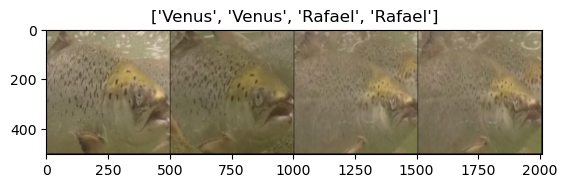

In [6]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

names = ['Novak','Rafael','Roger','Daniil','Dominic','Serena','Venus','Svetlana']

# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(list(inputs))

imshow(out, title=[names[x] for x in classes])

In [7]:
# Training method

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def train_model(model, criterion, optimizer, scheduler, num_epochs=5):

    best_model_params_path = 'model_weights1.pt'
    
    model.train()

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            
            inputs = torch.stack(inputs)
            labels = torch.tensor(labels)

            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
       
        scheduler.step()

        epoch_loss = running_loss / train_size
        epoch_acc = running_corrects / train_size

        print(f'Training Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    # Save best model weights
    torch.save(model.state_dict(), best_model_params_path)
    return model

In [8]:
# Initialize model

model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_classes = 9
model_ft.fc = nn.Linear(model_ft.fc.in_features, num_classes)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 2 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=2, gamma=0.1)


In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=1)

Epoch 0/0
----------
Training Loss: 0.8348 Acc: 0.7435


In [10]:
def test_model(model):
    was_training = model.training
    model.eval()
    
    predictions = []
    ground_truths = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            
            inputs = torch.stack(inputs)
            labels = torch.tensor(labels)


            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            predictions.extend(preds.tolist())
            ground_truths.extend(labels.tolist())
        
        
    return ground_truths, predictions

In [11]:
PATH = "/Users/magnuswiik/Documents/NTNU/5.klasse/prosjektoppgave/FishID/models/resnet18/model_weights1.pt"

model_ft.load_state_dict(torch.load(PATH))

ground_truths, predictions = test_model(model_ft)

print(sum(p.numel() for p in model_ft.parameters()))

11181129


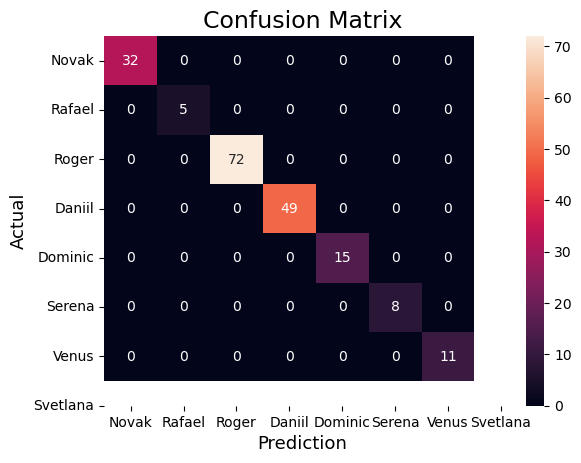

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

matrix = confusion_matrix(ground_truths, predictions)
g = np.unique(ground_truths)

sns.heatmap(matrix, 
            annot=True,
            fmt='g', 
            xticklabels=['Novak','Rafael','Roger','Daniil','Dominic','Serena','Venus','Svetlana'],
            yticklabels=['Novak','Rafael','Roger','Daniil','Dominic','Serena','Venus','Svetlana'])
plt.xlabel('Prediction',fontsize=13)
plt.ylabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [13]:
def visualize_model(model, num_images=6):
    names = ['Novak','Rafael','Roger','Daniil','Dominic','Serena','Venus','Svetlana']
    
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            inputs = torch.stack(inputs)
            labels = torch.tensor(labels)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {names[preds[j]]}, correct: {names[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

/Users/magnuswiik/miniconda3/envs/fisketrening/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


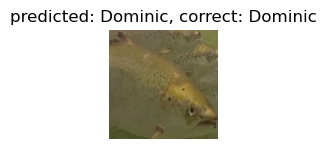

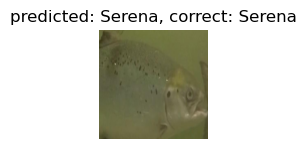

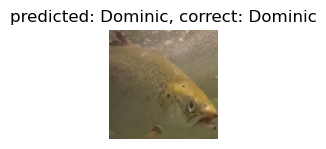

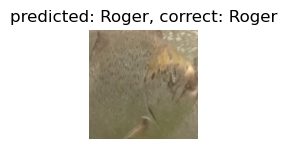

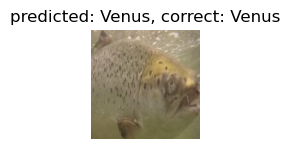

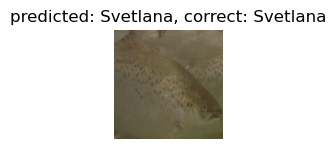

In [14]:
visualize_model(model_ft)